In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from collections import Generator
from enum import Enum, auto
import pandas as pd
import seaborn as sns

## Simulation States

In [3]:
class HealthState(Enum):
    NORMAL = 1
    LOW_RISK_POLYP = 2
    HIGH_RISK_POLYP = 3
    ADENOMA = 4
    CRC_STAGE1 = 5
    CRC_STAGE2 = 6
    CRC_STAGE3 = 7
    CRC_STAGE4 = 8
    DEATH_OTHER_CAUSES = 9
    DEATH_CRC = 10
    DEATH_FROM_SCREENING = 11
    TREATED_CRCSTAGE1 = 12
    TREATED_CRCSTAGE2 = 13
    TREATED_CRCSTAGE3 = 14
    TREATED_CRCSTAGE4 = 15


class Sex(Enum):
    MALE = 1
    FEMALE = 2


class Procedure(Enum):
    GFOBT = 1
    FIT = 2
    FIT_FS = 3
    COLONOSCOPY = 4
    POLYPECTOMY = 5
    BIOPSY = 6
    ADENOMA_REMOVAL = 7
    CRC_TREATMENT1 = 8
    CRC_TREATMENT2 = 9
    CRC_TREATMENT3 = 10
    CRC_TREATMENT4 = 11


## Parameters

In [4]:
health_prevalence_rate = {
    HealthState.NORMAL: 0.699,
    HealthState.LOW_RISK_POLYP: 0.1216,
    HealthState.HIGH_RISK_POLYP: 0.0749,
    HealthState.ADENOMA: 0.079,
    HealthState.CRC_STAGE1: 0.015,
    HealthState.CRC_STAGE2: 0.0105
}


In [5]:
age_mortality_rate = {
    Sex.MALE: {
        54: 0.0076,
        59: 0.0089,
        64: 0.0102,
        69: 0.0106,
    },
    Sex.FEMALE: {
        54: 0.0054,
        59: 0.0065,
        64: 0.0077,
        69: 0.0089,
    }
}


In [6]:
health_state_transition_rate = {
    HealthState.NORMAL: {
        HealthState.ADENOMA: 0.013,
        HealthState.LOW_RISK_POLYP: 0.016,
        HealthState.NORMAL: 0.971
    },
    HealthState.LOW_RISK_POLYP: {
        HealthState.HIGH_RISK_POLYP: 0.02,
        HealthState.ADENOMA: 0.05,
        HealthState.LOW_RISK_POLYP: 0.93,
    },
    HealthState.HIGH_RISK_POLYP: {
        HealthState.CRC_STAGE1: 0.0326,
        HealthState.CRC_STAGE2: 0.0174,
        HealthState.HIGH_RISK_POLYP: 0.95,
    },
    HealthState.ADENOMA: {
        HealthState.CRC_STAGE1: 0.016,
        HealthState.CRC_STAGE2: 0.016,
        HealthState.ADENOMA: 0.968
    },
    HealthState.CRC_STAGE1: {
        HealthState.CRC_STAGE1: 0.7,
        HealthState.CRC_STAGE2: 0.3,
    },
    HealthState.CRC_STAGE2: {
        HealthState.DEATH_CRC: 0.01,
        HealthState.CRC_STAGE2: 0.69,
        HealthState.CRC_STAGE3: 0.3,
    },
    HealthState.CRC_STAGE3: {
        HealthState.DEATH_CRC: 0.06,
        HealthState.CRC_STAGE3: 0.375,
        HealthState.CRC_STAGE4: 0.565,
    },
    HealthState.CRC_STAGE4: {
        HealthState.DEATH_CRC: 0.387,
        HealthState.CRC_STAGE4: 0.613,
    },
    # Treated CRC Mortality Rate
    HealthState.TREATED_CRCSTAGE1: {
        HealthState.TREATED_CRCSTAGE1: 1,
    },
    HealthState.TREATED_CRCSTAGE2: {
        HealthState.DEATH_CRC: 0.005,
        HealthState.TREATED_CRCSTAGE2: 0.995,
    },
    HealthState.TREATED_CRCSTAGE3: {
        HealthState.DEATH_CRC: 0.03,
        HealthState.TREATED_CRCSTAGE3: 0.97,
    },
    HealthState.TREATED_CRCSTAGE4: {
        HealthState.DEATH_CRC: 0.193,
        HealthState.TREATED_CRCSTAGE4: 0.807
    },
}


In [7]:
symptomatic_crc_detection_rate = {
    HealthState.CRC_STAGE1: 0.2,
    HealthState.CRC_STAGE2: 0.2,
    HealthState.CRC_STAGE3: 0.65,
    HealthState.CRC_STAGE4: 1
}


In [8]:
treatment_survival_rate = {
    HealthState.CRC_STAGE1: 1,
    HealthState.CRC_STAGE2: 0.995,
    HealthState.CRC_STAGE3: 0.97,
    HealthState.CRC_STAGE4: 0.387,
}


In [9]:
utilities = {
    HealthState.NORMAL: 1,
    HealthState.LOW_RISK_POLYP: 0.871,
    HealthState.HIGH_RISK_POLYP: 0.827,
    HealthState.ADENOMA: 1,
    HealthState.CRC_STAGE1: 0.8295,
    HealthState.CRC_STAGE2: 0.859,
    HealthState.CRC_STAGE3: 0.8155,
    HealthState.CRC_STAGE4: 0.735,
    HealthState.TREATED_CRCSTAGE1: 0.8295,
    HealthState.TREATED_CRCSTAGE2: 0.859,
    HealthState.TREATED_CRCSTAGE3: 0.8155,
    HealthState.TREATED_CRCSTAGE4: 0.735,
    HealthState.DEATH_OTHER_CAUSES: 0,
    HealthState.DEATH_CRC: 0,
    HealthState.DEATH_FROM_SCREENING: 0
}

procedure_costs = {
    Procedure.GFOBT: 190.8731,
    Procedure.FIT: 404.5658,
    Procedure.FIT_FS: 4432.0871,
    Procedure.COLONOSCOPY: 5366.965,
    Procedure.POLYPECTOMY: 6311.9301,
    Procedure.BIOPSY: 3450,
    Procedure.ADENOMA_REMOVAL: 0,
    Procedure.CRC_TREATMENT1: 150000,
    Procedure.CRC_TREATMENT2: 283333.3333,
    Procedure.CRC_TREATMENT3: 350000,
    Procedure.CRC_TREATMENT4: 0,
}

In [10]:
colonoscopy_positive_detection_rate = {
    HealthState.NORMAL: 0,
    HealthState.LOW_RISK_POLYP: 0.5,
    HealthState.HIGH_RISK_POLYP: 0.5,
    HealthState.ADENOMA: 0.87,
    HealthState.CRC_STAGE1: 0.999,
    HealthState.CRC_STAGE2: 0.999,
    HealthState.CRC_STAGE3: 0.999,
    HealthState.CRC_STAGE4: 0.999
}

# Derived from Speci/Sensi/Prevalence using http://vassarstats.net/clin2.html
screening_modalities_positive_detection_rate = {
    Procedure.GFOBT: {
        HealthState.NORMAL: 0.8784,
        HealthState.LOW_RISK_POLYP: 0.9,
        HealthState.HIGH_RISK_POLYP: 0.9,
        HealthState.ADENOMA: 0.583,
        HealthState.CRC_STAGE1: 0.8305,
        HealthState.CRC_STAGE2: 0.8305,
        HealthState.CRC_STAGE3: 0.8305,
        HealthState.CRC_STAGE4: 0.8305
    },
    Procedure.FIT: {
        HealthState.NORMAL: 0.4608,
        HealthState.LOW_RISK_POLYP: 0.9,
        HealthState.HIGH_RISK_POLYP: 0.9,
        HealthState.ADENOMA: 0.795,
        HealthState.CRC_STAGE1: 0.9,
        HealthState.CRC_STAGE2: 0.9,
        HealthState.CRC_STAGE3: 0.9,
        HealthState.CRC_STAGE4: 0.9
    },
    Procedure.FIT_FS: {
        HealthState.NORMAL: 0.01,
        HealthState.LOW_RISK_POLYP: 0.99,
        HealthState.HIGH_RISK_POLYP: 0.99,
        HealthState.ADENOMA: 0.795,
        HealthState.CRC_STAGE1: 0.995,
        HealthState.CRC_STAGE2: 0.995,
        HealthState.CRC_STAGE3: 0.995,
        HealthState.CRC_STAGE4: 0.995
    }
}

colonoscopy_mortality_rate = 0.001296 * 0.1 + 0.003037 * 0.007453
adenoma_removal_success_rate = 0.6
qaly_discounting = 0.03
cost_discounting = 0.03

## Simulation Classes and Functions

In [11]:
class RandomCVGenerator(Generator):
    def __init__(self, seed=427):
        self.seed_genX = np.random.RandomState(seed)

    def send(self, stub):
        randomX = self.seed_genX.rand()
        return randomX

    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration


In [12]:
def dict_to_cumulative(d):
    res = {}
    for k, v in d.items():
        res[v] = k
    return res


In [13]:
to_treated = {
    HealthState.CRC_STAGE1: HealthState.TREATED_CRCSTAGE1,
    HealthState.CRC_STAGE2: HealthState.TREATED_CRCSTAGE2,
    HealthState.CRC_STAGE3: HealthState.TREATED_CRCSTAGE3,
    HealthState.CRC_STAGE4: HealthState.TREATED_CRCSTAGE4
}

to_treatment = {
    HealthState.CRC_STAGE1: Procedure.CRC_TREATMENT1,
    HealthState.CRC_STAGE2: Procedure.CRC_TREATMENT2,
    HealthState.CRC_STAGE3: Procedure.CRC_TREATMENT3,
    HealthState.CRC_STAGE4: Procedure.CRC_TREATMENT4
}


In [14]:
class Individual(object):
    def __init__(self, state_prob, sex_prob, init_states_prob={}):
        self.state = self.init_health_state(state_prob, init_states_prob)
        self.age = 50
        self.procedures = np.array([])
        self.previous_states = np.array([])
        self.sex = Sex.MALE if sex_prob < 0.5 else Sex.FEMALE
        self.qalys = 0
        self.costs = 0
        self.years_til_colonoscopy = 0
        self.get_FOBT = True
        
        if self.state is None:
            raise Exception('No State!')

    def init_health_state(self, state_prob, states):
        if states == {}:
            states = {
                HealthState.NORMAL: 0.699,
                HealthState.LOW_RISK_POLYP: 0.1216,
                HealthState.HIGH_RISK_POLYP: 0.0749,
                HealthState.ADENOMA: 0.079,
                HealthState.CRC_STAGE1: 0.02,
                HealthState.CRC_STAGE2: 0.0055
            }

        # We just transpose the health states and probs
        # to compare with the random number generated
        states_conv = dict_to_cumulative(states)
        prev_k = 0
        sum_k = 0
        for k, v in states_conv.items():
            sum_k += k
            if prev_k <= state_prob < sum_k:
                return v
            prev_k += k

    @property
    def is_dead(self):
        if self.state == HealthState.DEATH_CRC or \
                self.state == HealthState.DEATH_FROM_SCREENING or \
                self.state == HealthState.DEATH_OTHER_CAUSES:
            return True
        else:
            return False

    @property
    def is_treated(self):
        if self.state == HealthState.TREATED_CRCSTAGE1 or \
                self.state == HealthState.TREATED_CRCSTAGE2 or \
                self.state == HealthState.TREATED_CRCSTAGE3 or \
                self.state == HealthState.TREATED_CRCSTAGE4:
            return True
        else:
            return False
        
    @property
    def has_cancer(self):
        if self.state == HealthState.CRC_STAGE1 or \
                self.state == HealthState.CRC_STAGE2 or \
                self.state == HealthState.CRC_STAGE3 or \
                self.state == HealthState.CRC_STAGE4:
            return True
        else:
            return False

    def __str__(self):
        return f'{self.age}: {self.state}'

    def __repr__(self):
        return self.__str__()


## Screening Strategies

In [15]:
def compute_other_mortality(individual):
    sex_mortality = age_mortality_rate[individual.sex]
    for k, v in sex_mortality.items():
        if individual.age > k:
            continue
        else:
            return v
    return


In [16]:
def no_screening(individual, num_gen):
    # Check dead
    if individual.is_dead:
        return None

    # Record Previous State
    individual.previous_states = np.append(
        individual.previous_states, individual.state)

    # Rates
    symptom_rate = symptomatic_crc_detection_rate.get(individual.state)
    asm_rate = compute_other_mortality(individual)

    # Symptomatic Representation
    if symptom_rate is not None and symptom_rate <= next(num_gen) and not individual.is_treated:
        treatment_survival_prob = next(num_gen)
        if treatment_survival_prob <= treatment_survival_rate[individual.state]:
            # Get the procedure for treatment
            proc = to_treatment[individual.state]
            individual.procedures = np.append(
                individual.procedures, proc)
            individual.costs += procedure_costs[proc] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
            # Convert to treated
            individual.state = to_treated[individual.state]
        else:
            # Copy paste sadness
            ht_rate = health_state_transition_rate[individual.state]
            # We just transpose the health states and probs
            # to compare with the random number generated
            states_conv = dict_to_cumulative(ht_rate)
            prev_k = 0
            sum_k = 0
            htr_prob = next(num_gen)
            for k, v in states_conv.items():
                sum_k += k
                if prev_k <= htr_prob < sum_k:
                    individual.state = v
                prev_k += k

    # Natural Health Transition
    elif next(num_gen) > asm_rate:
        ht_rate = health_state_transition_rate[individual.state]
        # We just transpose the health states and probs
        # to compare with the random number generated
        states_conv = dict_to_cumulative(ht_rate)
        prev_k = 0
        sum_k = 0
        htr_prob = next(num_gen)
        for k, v in states_conv.items():
            sum_k += k
            if prev_k <= htr_prob < sum_k:
                individual.state = v
            prev_k += k
    # Death from other causes
    else:
        individual.state = HealthState.DEATH_OTHER_CAUSES

    individual.qalys += utilities[individual.state] / ((1 + qaly_discounting) ** (individual.age - (individual.age - 1)))


In [17]:
def colonoscopy_screening(individual, num_gen, compliance_rate_thresh):
    # Check dead
    if individual.is_dead:
        return None

    # Record Previous State
    individual.previous_states = np.append(
        individual.previous_states, individual.state)

    # Rates
    symptom_rate = symptomatic_crc_detection_rate.get(individual.state)
    asm_rate = compute_other_mortality(individual)

    # Screening
    if next(num_gen) <= compliance_rate_thresh and \
            individual.years_til_colonoscopy == 0 and \
            not individual.is_treated:

        # Get colonoscopy
        individual.procedures = np.append(
            individual.procedures, Procedure.COLONOSCOPY)
        individual.costs += procedure_costs[Procedure.COLONOSCOPY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

        # Probability of bleeding/perforation death
        if next(num_gen) <= colonoscopy_mortality_rate:
            individual.state = HealthState.DEATH_FROM_SCREENING

        else:
            if next(num_gen) <= colonoscopy_positive_detection_rate[individual.state]:

                # Get Biopsy
                individual.procedures = np.append(
                    individual.procedures, Procedure.BIOPSY)
                individual.costs += procedure_costs[Procedure.BIOPSY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

                if individual.state == HealthState.LOW_RISK_POLYP or \
                        individual.state == HealthState.HIGH_RISK_POLYP:

                    # Get Polypectomy
                    individual.procedures = np.append(
                        individual.procedures, Procedure.POLYPECTOMY)
                    individual.costs += procedure_costs[Procedure.POLYPECTOMY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
                    individual.state = HealthState.NORMAL

                elif individual.state == HealthState.ADENOMA:

                    # Get Adenoma Removal Surgery
                    individual.procedures = np.append(
                        individual.procedures, Procedure.ADENOMA_REMOVAL)
                    individual.costs += procedure_costs[Procedure.ADENOMA_REMOVAL] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

                    if next(num_gen) <= adenoma_removal_success_rate:
                        individual.state = HealthState.NORMAL
                    else:
                        individual.state = HealthState.ADENOMA

                elif individual.has_cancer:

                    # Copy paste sadness
                    treatment_survival_prob = next(num_gen)
                    if treatment_survival_prob <= treatment_survival_rate[individual.state]:
                        # Get the procedure for treatment
                        proc = to_treatment[individual.state]
                        individual.procedures = np.append(
                            individual.procedures, proc)
                        individual.costs += procedure_costs[proc] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
                        # Convert to treated
                        individual.state = to_treated[individual.state]
                    else:
                        # Copy paste sadness
                        ht_rate = health_state_transition_rate[individual.state]
                        # We just transpose the health states and probs
                        # to compare with the random number generated
                        states_conv = dict_to_cumulative(ht_rate)
                        prev_k = 0
                        sum_k = 0
                        htr_prob = next(num_gen)
                        for k, v in states_conv.items():
                            sum_k += k
                            if prev_k <= htr_prob < sum_k:
                                individual.state = v
                            prev_k += k
                else:
                    raise Exception(f'{i.state} - This should not happen')

                individual.years_til_colonoscopy = 1

            else:
                individual.years_til_colonoscopy = 10

    # Symptomatic Representation
    elif symptom_rate is not None and symptom_rate <= next(num_gen) and not individual.is_treated:
        if next(num_gen) <= treatment_survival_rate[individual.state]:
            # Get the procedure for treatment
            proc = to_treatment[individual.state]
            individual.procedures = np.append(
                individual.procedures, proc)
            individual.costs += procedure_costs[proc] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
            # Convert to treated
            individual.state = to_treated[individual.state]
        else:
            # Copy paste sadness
            ht_rate = health_state_transition_rate[individual.state]
            # We just transpose the health states and probs
            # to compare with the random number generated
            states_conv = dict_to_cumulative(ht_rate)
            prev_k = 0
            sum_k = 0
            htr_prob = next(num_gen)
            for k, v in states_conv.items():
                sum_k += k
                if prev_k <= htr_prob < sum_k:
                    individual.state = v
                prev_k += k

    # Natural Health Transition
    elif next(num_gen) > asm_rate:
        ht_rate = health_state_transition_rate[individual.state]
        # We just transpose the health states and probs
        # to compare with the random number generated
        states_conv = dict_to_cumulative(ht_rate)
        prev_k = 0
        sum_k = 0
        htr_prob = next(num_gen)
        for k, v in states_conv.items():
            sum_k += k
            if prev_k <= htr_prob < sum_k:
                individual.state = v
            prev_k += k
    # Death from other causes
    else:
        individual.state = HealthState.DEATH_OTHER_CAUSES

    individual.qalys += utilities[individual.state] / ((1 + qaly_discounting) ** (individual.age - (individual.age - 1)))
    if individual.years_til_colonoscopy > 0:
        individual.years_til_colonoscopy -= 1

In [18]:
def FOBT_screening(individual, num_gen, compliance_rate_thresh1, compliance_rate_thresh2, screening_modality):
    # Check dead
    if individual.is_dead:
        return None

    # Record Previous State
    individual.previous_states = np.append(
        individual.previous_states, individual.state)

    # Rates
    symptom_rate = symptomatic_crc_detection_rate.get(individual.state)
    asm_rate = compute_other_mortality(individual)

    if next(num_gen) <= compliance_rate_thresh1 and individual.get_FOBT and not individual.is_treated:

        individual.procedures = np.append(
            individual.procedures, screening_modality)
        individual.costs += procedure_costs[screening_modality] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

        fobt_detection_rate = screening_modalities_positive_detection_rate[
            screening_modality][individual.state]
        if next(num_gen) <= fobt_detection_rate:
            # Colonoscopy Screening
            if next(num_gen) <= compliance_rate_thresh2:
                # Get colonoscopy
                individual.procedures = np.append(
                    individual.procedures, Procedure.COLONOSCOPY)
                individual.costs += procedure_costs[Procedure.COLONOSCOPY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

                # Probability of bleeding/perforation death
                if next(num_gen) <= colonoscopy_mortality_rate:
                    individual.state = HealthState.DEATH_FROM_SCREENING

                else:
                    if next(num_gen) <= colonoscopy_positive_detection_rate[individual.state]:

                        # Get Biopsy
                        individual.procedures = np.append(
                            individual.procedures, Procedure.BIOPSY)
                        individual.costs += procedure_costs[Procedure.BIOPSY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

                        if individual.state == HealthState.LOW_RISK_POLYP or \
                                individual.state == HealthState.HIGH_RISK_POLYP:

                            # Get Polypectomy
                            individual.procedures = np.append(
                                individual.procedures, Procedure.POLYPECTOMY)
                            individual.costs += procedure_costs[Procedure.POLYPECTOMY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
                            individual.state = HealthState.NORMAL
                            individual.get_FOBT = True

                        elif individual.state == HealthState.ADENOMA:

                            # Get Adenoma Removal Surgery
                            individual.procedures = np.append(
                                individual.procedures, Procedure.ADENOMA_REMOVAL)
                            individual.costs += procedure_costs[Procedure.ADENOMA_REMOVAL] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

                            if next(num_gen) <= adenoma_removal_success_rate:
                                individual.state = HealthState.NORMAL
                                individual.get_FOBT = True
                            else:
                                individual.state = HealthState.ADENOMA

                        elif individual.has_cancer:

                            # Copy paste sadness
                            treatment_survival_prob = next(num_gen)
                            if treatment_survival_prob <= treatment_survival_rate[individual.state]:
                                # Get the procedure for treatment
                                proc = to_treatment[individual.state]
                                individual.procedures = np.append(
                                    individual.procedures, proc)
                                individual.costs += procedure_costs[proc] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
                                # Convert to treated
                                individual.state = to_treated[individual.state]
                            else:
                                # Copy paste sadness
                                ht_rate = health_state_transition_rate[individual.state]
                                # We just transpose the health states and probs
                                # to compare with the random number generated
                                states_conv = dict_to_cumulative(ht_rate)
                                prev_k = 0
                                sum_k = 0
                                htr_prob = next(num_gen)
                                for k, v in states_conv.items():
                                    sum_k += k
                                    if prev_k <= htr_prob < sum_k:
                                        individual.state = v
                                    prev_k += k
                        else:
                            raise Exception(
                                f'{i.state} - This should not happen')

                        individual.years_til_colonoscopy = 1
                        individual.get_FOBT = False

                    else:
                        individual.years_til_colonoscopy = 10
                        individual.get_FOBT = False

    # Colonoscopy Screening
    elif next(num_gen) <= compliance_rate_thresh2 and \
            individual.years_til_colonoscopy == 0 and \
            not individual.is_treated and not individual.get_FOBT:

        # Get colonoscopy
        individual.procedures = np.append(
            individual.procedures, Procedure.COLONOSCOPY)
        individual.costs += procedure_costs[Procedure.COLONOSCOPY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

        # Probability of bleeding/perforation death
        if next(num_gen) <= colonoscopy_mortality_rate:
            individual.state = HealthState.DEATH_FROM_SCREENING

        else:
            if next(num_gen) <= colonoscopy_positive_detection_rate[individual.state]:

                # Get Biopsy
                individual.procedures = np.append(
                    individual.procedures, Procedure.BIOPSY)
                individual.costs += procedure_costs[Procedure.BIOPSY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

                if individual.state == HealthState.LOW_RISK_POLYP or \
                        individual.state == HealthState.HIGH_RISK_POLYP:

                    # Get Polypectomy
                    individual.procedures = np.append(
                        individual.procedures, Procedure.POLYPECTOMY)
                    individual.costs += procedure_costs[Procedure.POLYPECTOMY] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
                    individual.state = HealthState.NORMAL
                    individual.get_FOBT = True

                elif individual.state == HealthState.ADENOMA:

                    # Get Adenoma Removal Surgery
                    individual.procedures = np.append(
                        individual.procedures, Procedure.ADENOMA_REMOVAL)
                    individual.costs += procedure_costs[Procedure.ADENOMA_REMOVAL] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))

                    if next(num_gen) <= adenoma_removal_success_rate:
                        individual.state = HealthState.NORMAL
                        individual.get_FOBT = True
                    else:
                        individual.state = HealthState.ADENOMA

                elif individual.has_cancer:

                    # Copy paste sadness
                    treatment_survival_prob = next(num_gen)
                    if treatment_survival_prob <= treatment_survival_rate[individual.state]:
                        # Get the procedure for treatment
                        proc = to_treatment[individual.state]
                        individual.procedures = np.append(
                            individual.procedures, proc)
                        individual.costs += procedure_costs[proc] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
                        # Convert to treated
                        individual.state = to_treated[individual.state]
                    else:
                        # Copy paste sadness
                        ht_rate = health_state_transition_rate[individual.state]
                        # We just transpose the health states and probs
                        # to compare with the random number generated
                        states_conv = dict_to_cumulative(ht_rate)
                        prev_k = 0
                        sum_k = 0
                        htr_prob = next(num_gen)
                        for k, v in states_conv.items():
                            sum_k += k
                            if prev_k <= htr_prob < sum_k:
                                individual.state = v
                            prev_k += k
                else:
                    raise Exception(f'{i.state} - This should not happen')

                individual.years_til_colonoscopy = 1

            else:
                individual.years_til_colonoscopy = 10

    # Symptomatic Representation
    elif symptom_rate is not None and symptom_rate <= next(num_gen) and not individual.is_treated:
        if next(num_gen) <= treatment_survival_rate[individual.state]:
            # Get the procedure for treatment
            proc = to_treatment[individual.state]
            individual.procedures = np.append(
                individual.procedures, proc)
            individual.costs += procedure_costs[proc] / ((1 + cost_discounting) ** (individual.age - (individual.age - 1)))
            # Convert to treated
            individual.state = to_treated[individual.state]
        else:
            # Copy paste sadness
            ht_rate = health_state_transition_rate[individual.state]
            # We just transpose the health states and probs
            # to compare with the random number generated
            states_conv = dict_to_cumulative(ht_rate)
            prev_k = 0
            sum_k = 0
            htr_prob = next(num_gen)
            for k, v in states_conv.items():
                sum_k += k
                if prev_k <= htr_prob < sum_k:
                    individual.state = v
                prev_k += k

    # Natural Health Transition
    elif next(num_gen) > asm_rate:
        ht_rate = health_state_transition_rate[individual.state]
        # We just transpose the health states and probs
        # to compare with the random number generated
        states_conv = dict_to_cumulative(ht_rate)
        prev_k = 0
        sum_k = 0
        htr_prob = next(num_gen)
        for k, v in states_conv.items():
            sum_k += k
            if prev_k <= htr_prob < sum_k:
                individual.state = v
            prev_k += k
    # Death from other causes
    else:
        individual.state = HealthState.DEATH_OTHER_CAUSES

    individual.qalys += utilities[individual.state] / ((1 + qaly_discounting) ** (individual.age - (individual.age - 1)))
    if individual.years_til_colonoscopy > 0:
        individual.years_til_colonoscopy -= 1

In [19]:
def to_df(individuals):
    df = pd.DataFrame()
    df['life_years'] = np.array(
        [len(i.previous_states) if not i.is_dead else len(i.previous_states) + 1 for i in individuals])
    df['cost'] = np.array([i.costs for i in individuals])
    df['qalys'] = np.array([i.qalys for i in individuals])
    return df


## Test Bed for No Screening

In [20]:
individual_count = 10000
rand_individual_state_gen = RandomCVGenerator()
rand_individual_sex_gen = RandomCVGenerator(724)

individuals = [Individual(next(rand_individual_state_gen), next(rand_individual_sex_gen), 
                          init_states_prob=health_prevalence_rate)
               for _ in range(individual_count)]

(array([ 7016.,     0.,  1197.,     0.,   780.,     0.,   776.,     0.,
          143.,    88.]),
 array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ]),
 <a list of 10 Patch objects>)

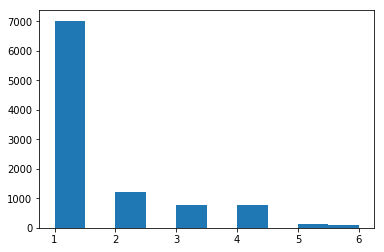

In [21]:
# Health State Distribution
hist(np.array([i.state.value for i in individuals]))

In [22]:
# Simulate!
sim_gen = RandomCVGenerator()
for k in range(20):
    for i in individuals:
        no_screening(i, sim_gen)
        i.age += 1

(array([  4.28600000e+03,   4.79000000e+02,   2.36000000e+03,
          8.00000000e+01,   7.00000000e+00,   3.00000000e+00,
          1.62800000e+03,   0.00000000e+00,   4.45000000e+02,
          7.12000000e+02]),
 array([  1. ,   2.3,   3.6,   4.9,   6.2,   7.5,   8.8,  10.1,  11.4,
         12.7,  14. ]),
 <a list of 10 Patch objects>)

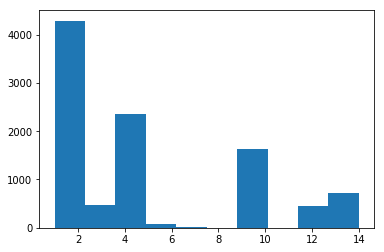

In [23]:
# Health State Outcomes
hist(np.array([i.state.value for i in individuals]))

In [24]:
prev_states = np.array([i.previous_states[-1].value for i in individuals if i.state.value == 10])
prev_states.shape


(75,)

(array([  2.,   4.,  24.,   0.,   0.,   0.,   0.,   0.,  40.,   5.]),
 array([  6. ,   6.8,   7.6,   8.4,   9.2,  10. ,  10.8,  11.6,  12.4,
         13.2,  14. ]),
 <a list of 10 Patch objects>)

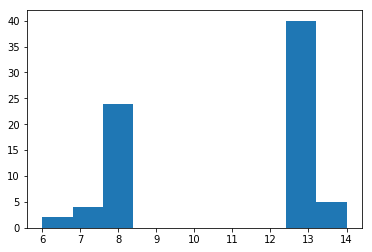

In [25]:
hist(prev_states)

In [26]:
QALYs = sum(np.array([i.qalys for i in individuals]))
costs = sum(np.array([i.costs for i in individuals]))
print(f'QALY: {QALYs}')
print(f'Costs: {costs}')
print(f'QALY Diff: {QALYs / (individual_count * 20)}')

QALY: 171544.5699029126
Costs: 300776699.00339806
QALY Diff: 0.857722849514563


(array([ 122.,    0.,   45.,    0.,    0.,    0.,  445.,    0.,  692.,   20.]),
 array([  9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
         13.5,  14. ]),
 <a list of 10 Patch objects>)

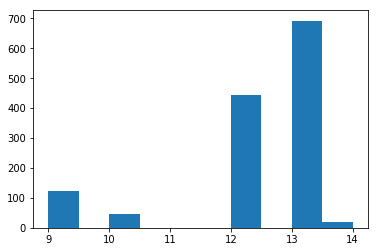

In [27]:
hist(
    np.array([i.state.value for i in individuals if len(i.procedures) == 1]))


## Test Bed for Colonoscopy Screening

In [28]:
individual_count = 10000
rand_individual_state_gen = RandomCVGenerator()
rand_individual_sex_gen = RandomCVGenerator(724)

individuals = [Individual(next(rand_individual_state_gen), next(rand_individual_sex_gen),
                          init_states_prob=health_prevalence_rate) for _ in range(individual_count)]

(array([ 7016.,     0.,  1197.,     0.,   780.,     0.,   776.,     0.,
          143.,    88.]),
 array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ]),
 <a list of 10 Patch objects>)

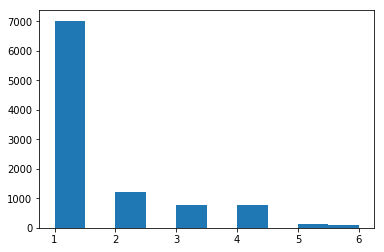

In [29]:
# Health State Distribution
hist(np.array([i.state.value for i in individuals]))

In [30]:
# Simulate!
sim_gen = RandomCVGenerator()
for k in range(20):
    for i in individuals:
        colonoscopy_screening(i, sim_gen, 1)
        i.age += 1

(array([  6.60800000e+03,   2.30000000e+02,   1.16300000e+03,
          2.80000000e+01,   1.00000000e+00,   1.00000000e+00,
          1.45500000e+03,   2.00000000e+00,   2.36000000e+02,
          2.76000000e+02]),
 array([  1. ,   2.3,   3.6,   4.9,   6.2,   7.5,   8.8,  10.1,  11.4,
         12.7,  14. ]),
 <a list of 10 Patch objects>)

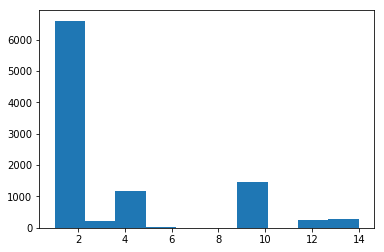

In [31]:
# Health State Outcomes
hist(np.array([i.state.value for i in individuals]))

In [32]:
prev_states = np.array([i.previous_states[-1].value for i in individuals if i.state.value == 10])
prev_states.shape


(25,)

(array([  1.,   0.,   5.,   0.,   0.,   0.,   0.,  18.,   0.,   1.]),
 array([  6. ,   6.9,   7.8,   8.7,   9.6,  10.5,  11.4,  12.3,  13.2,
         14.1,  15. ]),
 <a list of 10 Patch objects>)

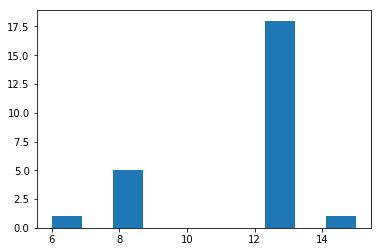

In [33]:
hist(prev_states)

In [34]:
QALYs = sum(np.array([i.qalys for i in individuals]))
costs = sum(np.array([i.costs for i in individuals]))
print(f'QALY: {QALYs}')
print(f'Costs: {costs}')
print(f'QALY Diff: {QALYs / (individual_count * 20)}')

QALY: 176833.47427184467
Costs: 276387519.30786407
QALY Diff: 0.8841673713592233


(array([ 46.,   4.,   0.,   6.,   0.,   0.,   0.,   0.,   0.,   4.]),
 array([ 1. ,  1.8,  2.6,  3.4,  4.2,  5. ,  5.8,  6.6,  7.4,  8.2,  9. ]),
 <a list of 10 Patch objects>)

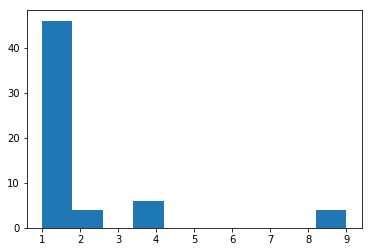

In [35]:
hist(
    np.array([i.state.value for i in individuals if len(i.procedures) == 14]))


## Test Bed for G-FOBT Screening

In [51]:
individual_count = 10000
rand_individual_state_gen = RandomCVGenerator()
rand_individual_sex_gen = RandomCVGenerator(724)

individuals = [Individual(next(rand_individual_state_gen), next(rand_individual_sex_gen),
                          init_states_prob=health_prevalence_rate) for _ in range(individual_count)]

(array([ 7016.,     0.,  1197.,     0.,   780.,     0.,   776.,     0.,
          143.,    88.]),
 array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ]),
 <a list of 10 Patch objects>)

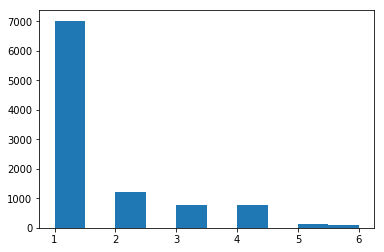

In [52]:
# Health State Distribution
hist(np.array([i.state.value for i in individuals]))

In [53]:
# Simulate!
sim_gen = RandomCVGenerator()
for k in range(20):
    for i in individuals:
        FOBT_screening(i, sim_gen, 1, 1, Procedure.FIT_FS)
        i.age += 1

(array([  6.64100000e+03,   1.90000000e+02,   1.23000000e+03,
          1.30000000e+01,   1.00000000e+00,   1.35500000e+03,
          2.50000000e+01,   2.76000000e+02,   2.62000000e+02,
          7.00000000e+00]),
 array([  1. ,   2.4,   3.8,   5.2,   6.6,   8. ,   9.4,  10.8,  12.2,
         13.6,  15. ]),
 <a list of 10 Patch objects>)

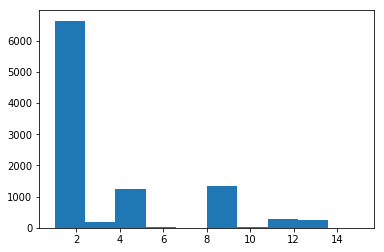

In [54]:
# Health State Outcomes
hist(np.array([i.state.value for i in individuals]))

In [55]:
prev_states = np.array([i.previous_states[-1].value for i in individuals if i.state.value == 11])
prev_states.shape


(4,)

(array([ 2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1. ,  1.3,  1.6,  1.9,  2.2,  2.5,  2.8,  3.1,  3.4,  3.7,  4. ]),
 <a list of 10 Patch objects>)

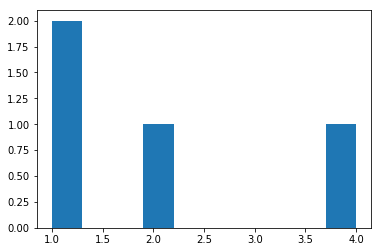

In [56]:
hist(prev_states)

In [57]:
QALYs = sum(np.array([i.qalys for i in individuals]))
costs = sum(np.array([i.costs for i in individuals]))
print(f'QALY: {QALYs}')
print(f'Costs: {costs}')
print(f'QALY Diff: {QALYs / (individual_count * 20)}')

QALY: 177375.34126213592
Costs: 281531581.6215534
QALY Diff: 0.8868767063106796


(array([ 40.,   3.,   1.,   0.,   0.,   0.,   2.,   0.,   0.,   1.]),
 array([  1. ,   2.2,   3.4,   4.6,   5.8,   7. ,   8.2,   9.4,  10.6,
         11.8,  13. ]),
 <a list of 10 Patch objects>)

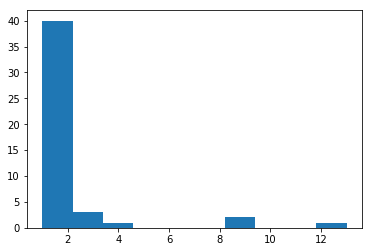

In [43]:
hist(
    np.array([i.state.value for i in individuals if len(i.procedures) == 14]))
